In [1]:
from  projectCode.imports import *

In [ ]:
device = set_device()
ann_file = "./annotations/annotations/captions_val2017.json"
num_examples = 512
batch_size = 1
seed = 42

cuda
loading annotations into memory...
Done (t=0.03s)
creating index...
index created!
Selected 512 images.


In [ ]:
ds = CocoDataset(ann_file, num_examples, img_dir = "imgs",seed = seed)
dl = DataLoader(ds, batch_size = batch_size)

In [ ]:
model_params={"device":device,"tokens_path":'./models/ExpansionNet_v2/demo_material/demo_coco_tokens.pickle',"blured":True}
model = loadModel("ExpansionNet",model_path="./models/ExpansionNet_v2/rf_model.pth",**model_params)

/home/captioning/miniconda3/envs/captioning/lib/python3.10/site-packages/torch/functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1720538459595/work/aten/src/ATen/native/TensorShape.cpp:3609.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/home/captioning/236874/projectCode/ModelLoader.py:177: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loade

In [4]:
def inv_perplexity(logits,sentence, filterModel):
    
    filter = filterModel(sentence)
    
    filtered_logits = logits[torch.tensor(filter,dtype=torch.bool)]
    
    probs = torch.softmax(filtered_logits, dim=1)  
    
    max_probs = probs.max(dim=1).values
    log_likelihood_normalized = max_probs.log().sum().div(len(filtered_logits))
    return torch.exp(log_likelihood_normalized)

In [10]:
perts = torch.load("./adversarial_attacks/ExpNet/v1/ExpNet_512_pert.pt").to(device)

file_path = "./adversarial_attacks/ExpNet/v1/ExpNet_512_1_cap.json"
with open(file_path, 'r') as openfile:
    captions = json.load(openfile)
eos_idx = 77
filterModel = loadModel( "POS",None)
cap_confidences = []
attacked_confidence = []
for i in range(512):
    if captions["scores"]["meteor"][i][0] < 0.4:
        continue
    
    img = ds[i][0].to(device)
    #out, pred, logits, _ = model(img.unsqueeze(0).to(device))
    out, pred, logits, _ = model(img.unsqueeze(0).to(device))
    out_a, pred_a, logits_a, _ = model(torch.clamp((img.unsqueeze(0) + perts[i]),0,1).to(device))

    end = pred[0][0].index(eos_idx)-1
    logits = logits.detach().to('cpu')[:end]
    
    if(out[0][-1] == '.'):
        out[0]= out[0][:-1]
    conf = inv_perplexity(logits=logits,sentence=out[0],filterModel=filterModel)
    cap_confidences.append(conf.item())

    end = pred_a[0][0].index(eos_idx)-1
    logits_a = logits_a.detach().to('cpu')[:end]
    
    if(out_a[0][-1] == '.'):
        out_a[0]= out_a[0][:-1]
    conf = inv_perplexity(logits=logits_a,sentence=out_a[0],filterModel=filterModel)
    attacked_confidence.append(conf.item())

print(sum(cap_confidences)/len(cap_confidences)) 

/tmp/ipykernel_309678/104274081.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  perts = torch.load("./adversarial_attacks/ExpNet/v1/ExpNet_512_pert.pt").to(device)


2025-03-02 16:50:28,563 SequenceTagger predicts: Dictionary with 53 tags: <unk>, O, UH, ,, VBD, PRP, VB, PRP$, NN, RB, ., DT, JJ, VBP, VBG, IN, CD, NNS, NNP, WRB, VBZ, WDT, CC, TO, MD, VBN, WP, :, RP, EX, JJR, FW, XX, HYPH, POS, RBR, JJS, PDT, NNPS, RBS, AFX, WP$, -LRB-, -RRB-, ``, '', LS, $, SYM, ADD
0.9460185360401234


In [11]:
def CDF(val_list,generator = None):
    if generator is None:
        generator = [i/100 for i in range(1,101)]
    l = len(val_list)
    cnf = []
    for i in generator:
        f_len = len(list(filter(lambda x: x < i , val_list)))
        frac = f_len/l
        cnf.append(frac)
    return cnf


In [12]:
steps = [i/100 for i in range(1,101)]
attacked_cdf = CDF(attacked_confidence,steps)
regular_cdf = CDF(cap_confidences,steps)

<function matplotlib.pyplot.show(close=None, block=None)>

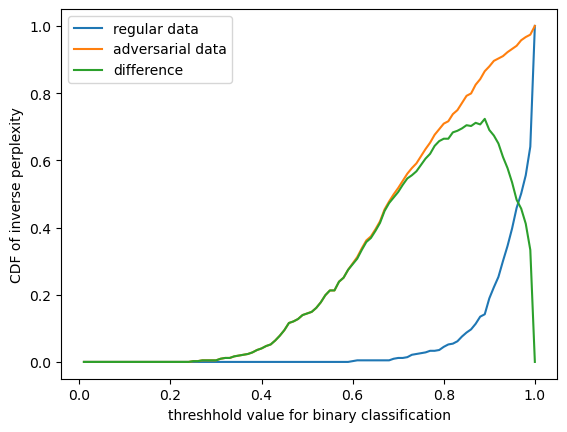

In [13]:
plt.plot(steps,regular_cdf,label="regular data")
plt.plot(steps,attacked_cdf,label="adversarial data")
cdf_diff = [at - reg for at,reg in zip(attacked_cdf,regular_cdf)]
plt.plot(steps,cdf_diff,label="difference")

plt.xlabel("threshhold value for binary classification")
plt.ylabel("CDF of inverse perplexity")


plt.legend()
plt.show

In [14]:
optimal_cnf_diff = max(cdf_diff)
opt_indx = cdf_diff.index(optimal_cnf_diff)
optimal_threshhold = steps[opt_indx]
print("Optimal threshhold is",optimal_threshhold)
tp = 1-regular_cdf[opt_indx]
tn = attacked_cdf[opt_indx]
fn = regular_cdf[opt_indx]
fp = 1-attacked_cdf[opt_indx]
print(f"TP = {tp}, FP = {fp}\nTN = {tn}, FN = {fn}")
precision = tp/(tp + fp)
recall = tp/(tp+fn)
f1 = 2*(precision*recall)/(precision+recall)
print(f"Precision = {precision}      Recall = {recall}       F_1 = {f1} ")

Optimal threshhold is 0.89
TP = 0.8581560283687943, FP = 0.13475177304964536
TN = 0.8652482269503546, FN = 0.14184397163120568
Precision = 0.8642857142857143      Recall = 0.8581560283687943       F_1 = 0.8612099644128114 


In [ ]:
def compute_likelihood(logits):
    probs = torch.softmax(logits, dim=1)  
    max_probs = probs.max(dim=1).values
    
    # Compute the log-likelihood (sum of logs of max probabilities)
    log_likelihood = max_probs.log().sum()  
    
    # Compute the likelihood (product of max probabilities)
    likelihood = max_probs.prod()  # Product over the sequence
    
    return log_likelihood, likelihood

In [ ]:
def compute_confidence(logits):
    word_confidences = []
    probs = torch.nn.functional.softmax(logits, dim=1)
    
    for i in range(logits.shape[0]):
        word_confidence = probs[i].max()                                                                                                                                                                                                                                                                                                                                                                
        word_confidences.append(word_confidence) 

    # Compute the average confidence for the whole caption
    avg_confidence = sum(word_confidences)/len(word_confidences)
    return avg_confidence, word_confidences

In [ ]:
cartoon_ds = CartoonDataset()
cartoon_dl = DataLoader(cartoon_ds, batch_size = 1)

In [ ]:
# Iterating over cartoon ds
lst=[]
for i, batch in enumerate(cartoon_dl):
    img, cap = batch
    _, _, logits, _ = model(img.to(device), gen_cap=False)
    logits = logits.detach().to('cpu')
    log_likelihood, likelihood = compute_likelihood(logits)
    lst.append(likelihood)
    #avg_confidence = torch.norm(torch.softmax(logits,dim=-1),p=2,dim=-1).mean()
    #avg_confidence, _ = compute_confidence(logits)

    '''
    if avg_confidence <= 0.85:
        print(f"Confidence: {avg_confidence}")
        plt.figure(figsize=(4, 4))
        plt.axis("off")
        plt.imshow(img.squeeze(0).permute(1, 2, 0))
        plt.show()
    '''

print(sum(lst)/len(lst))

KeyboardInterrupt: 

In [ ]:
# Iterating over COCO ds
lst=[]
for i, batch in enumerate(dl):
    img, cap = batch
    _, _, logits, _ = model(img.to(device))
    logits = logits.detach().to('cpu')
    log_likelihood, likelihood = compute_likelihood(logits)
    lst.append(likelihood)

print(sum(lst)/len(lst))